# Question 2
## Part a.
### GRU Model

This model was built using code from the lab notebooks for the EIRNN, but adapting it into a GRU. This means the main model classes are much more simplified in comparison. The structure of having the GRURNN class and GRUNet class separately isn't necessary, but it matches the method used for the EIRNN, thereby simplifying the implementation.

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import math
import logging
import neurogym as ngym
import matplotlib.pyplot as plt
import torch.optim as optim
import neurogym as ngym
import logging

In [ ]:
# Define GRU recurrent layer 
class GRURNN(nn.Module):
    """GRU Recurrent Neural Network.

    Parameters:
        input_size: Number of input features
        hidden_size: Number of hidden units in the GRU
        num_layers: Number of stacked GRU layers (optional, default=1)
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Use PyTorch's built-in GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.2)

    def forward(self, input, hidden=None):
        """Propagate input through the GRU."""
        # Forward pass through GRU
        output, hidden = self.gru(input, hidden)
        return output, hidden

In [ ]:
# Define GRUNet as the full model (basically the Net class for the EIRNN but with a GRU layer instead of a EIRNN layer)
class GRUNet(nn.Module):
    """Recurrent Network Model using GRU.

    Parameters:
        input_size: Number of input features
        hidden_size: Number of hidden units in the GRU
        output_size: Number of output features
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        # Replace LeakyRNN with GRURNN
        self.rnn = GRURNN(input_size, hidden_size, num_layers=num_layers)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Process the sequence through the GRU
        rnn_output, _ = self.rnn(x)

        # Map the GRU output to the output space
        out = self.fc(rnn_output)
        return out, rnn_output

In [ ]:
# Define model parameters

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=32,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [ ]:
# Define GRUNet parameters
hidden_size = 200
num_layers = 2

# Instantiate the network
net = GRUNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
print(net)

# Optimizer with weight decay and learning rate scheduler
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
# During training, define the criterion with ignore_index
criterion = nn.CrossEntropyLoss(ignore_index=-1)

GRUNet(
  (rnn): GRURNN(
    (gru): GRU(3, 200, num_layers=2, dropout=0.2)
  )
  (fc): Linear(in_features=200, out_features=3, bias=True)
)


Step 200, Loss 0.5388
Step 400, Loss 0.2178
Step 600, Loss 0.1390
Step 800, Loss 0.1182
Step 1000, Loss 0.1097
Step 1200, Loss 0.0772
Step 1400, Loss 0.0645
Step 1600, Loss 0.0638
Step 1800, Loss 0.0618
Step 2000, Loss 0.0603
Step 2200, Loss 0.0596
Step 2400, Loss 0.0596
Step 2600, Loss 0.0600
Step 2800, Loss 0.0578
Step 3000, Loss 0.0581
Step 3200, Loss 0.0578
Step 3400, Loss 0.0577
Step 3600, Loss 0.0563
Step 3800, Loss 0.0569
Step 4000, Loss 0.0580
Step 4200, Loss 0.0573
Step 4400, Loss 0.0567
Step 4600, Loss 0.0558
Step 4800, Loss 0.0560
Step 5000, Loss 0.0573


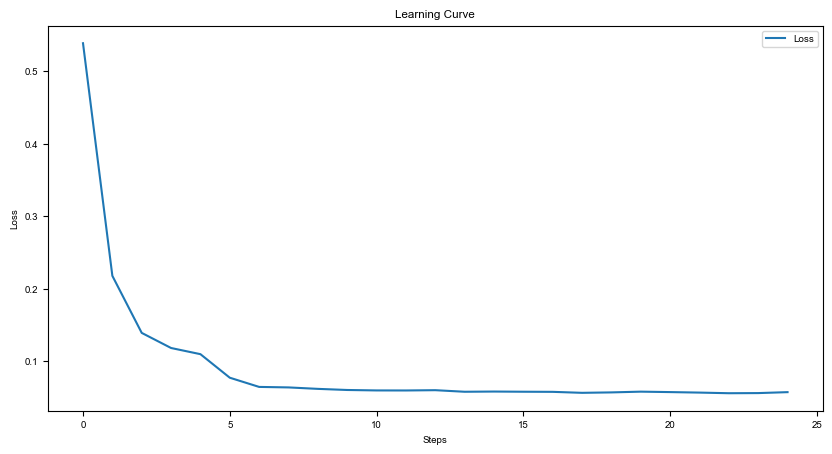

In [ ]:
# Training Loop (same as EIRNN code)
loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)
    # Zero the gradient buffers
    optimizer.zero_grad()
    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)
    # Compute loss
    loss = criterion(output, labels)
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

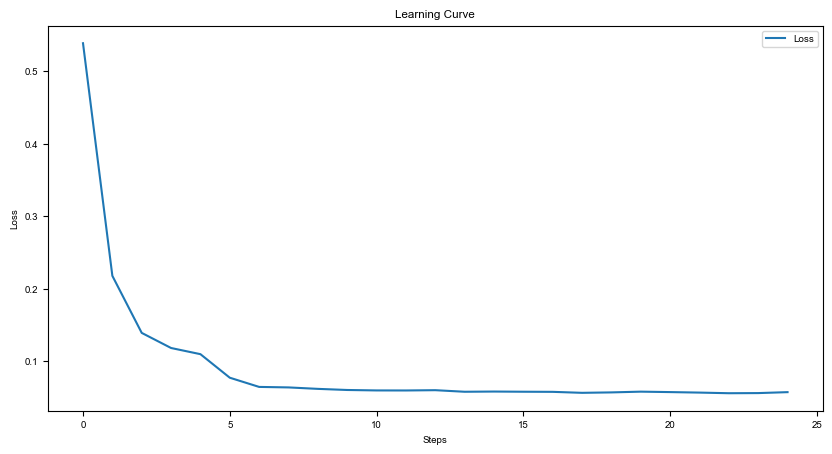

In [46]:
# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model (same as EIRNN code)
# Set the network to evaluation mode
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0 # Initialize performance
num_trial = 500 # Number of trials to run
activity_dict = {} # Dictionary to store activity for each trial
trial_infos = {} # Dictionary to store trial info
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial): # Loop over trials
    env.new_trial()
    ob, gt = env.ob, env.gt # Get observation and ground-truth
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float) # Convert observation to tensor
    action_pred, rnn_activity = net(inputs) # Forward pass

    # Compute performance
    action_pred = action_pred.detach().numpy() # Convert to numpy
    choice = np.argmax(action_pred[-1, 0, :]) # Get the choice
    correct = choice == gt[-1] # Check if choice is correct

    # Log trial info
    trial_info = env.trial # Get trial info
    trial_info.update({'correct': correct, 'choice': choice}) # Update trial info
    trial_infos[i] = trial_info # Store trial info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy() # Convert to numpy
    activity_dict[i] = rnn_activity # Store activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']] # Get stimulus period activity
    stim_activity[env.trial['ground_truth']].append(rnn_activity) # Append activity to corresponding ground-truth

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.858


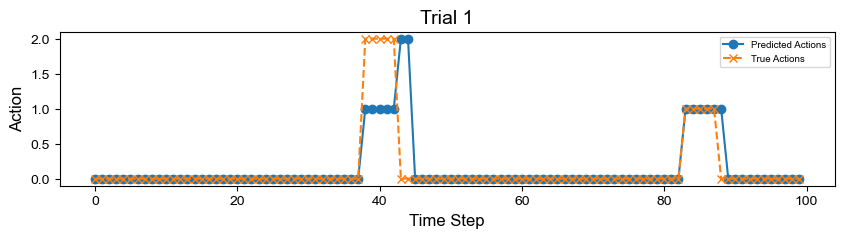

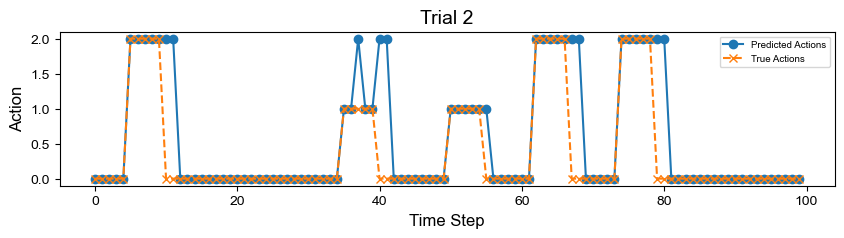

In [ ]:
# Ensure compatibility with dataset output format
with torch.no_grad(): # Disable gradient tracking
    inputs, labels = dataset()  # Unpack the dataset tuple
    inputs = torch.from_numpy(inputs).type(torch.float)  # Convert inputs to PyTorch tensor
    inputs = (inputs - inputs.mean()) / inputs.std()  # Normalise inputs

    preds, _ = net(inputs)  # Pass inputs through the model
    predicted_actions = preds.argmax(dim=-1).cpu().numpy()  # Extract predicted actions

for trial in range(2): # Plot the first two trials
    plt.figure(figsize=(10, 2))
    plt.title(f"Trial {trial + 1}", fontsize=14)
    plt.plot(predicted_actions[:, trial], label='Predicted Actions', marker='o')
    plt.plot(labels[:, trial], label='True Actions', linestyle='--', marker='x')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Action", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.show()

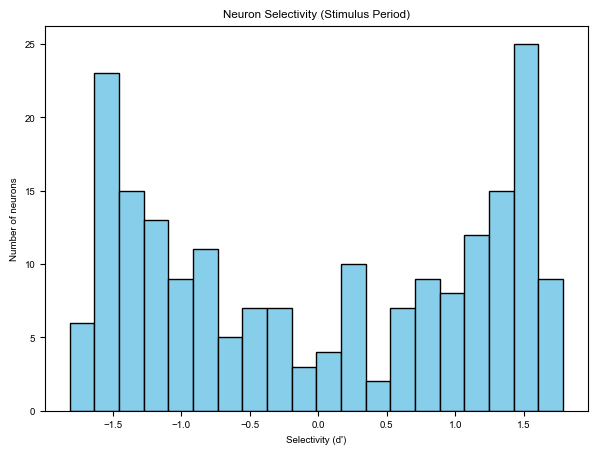

In [ ]:
# Plotting the activity of a single neuron (Adapted from EIRNN code)

# Compute stimulus selectivity for neurons
mean_activity = [] 
std_activity = []
for ground_truth in [0, 1]: # Loop over ground-truths
    if stim_activity[ground_truth]:  # Ensure non-empty activity list
        activity = np.concatenate(stim_activity[ground_truth], axis=0)  # Shape: (total_time_steps, hidden_size)
        mean_activity.append(np.mean(activity, axis=0))  # Mean over time steps
        std_activity.append(np.std(activity, axis=0))    # Std over time steps
    else:
        mean_activity.append(np.zeros(net.rnn.hidden_size)) # Zero mean for empty activity
        std_activity.append(np.ones(net.rnn.hidden_size)) # Unit std for empty activity

# Calculate selectivity (d') for neurons
epsilon = 1e-7  # Small value to prevent division by zero
selectivity = (mean_activity[1] - mean_activity[0])  # Difference between means
selectivity /= np.sqrt((std_activity[0] ** 2 + std_activity[1] ** 2 + epsilon) / 2)  # Pooled standard deviation

# Plot selectivity distribution
plt.figure(figsize=(7, 5))
plt.hist(selectivity, bins=20, color="skyblue", edgecolor="black")
plt.title("Neuron Selectivity (Stimulus Period)")
plt.xlabel("Selectivity (d')")
plt.ylabel("Number of neurons")
plt.show()

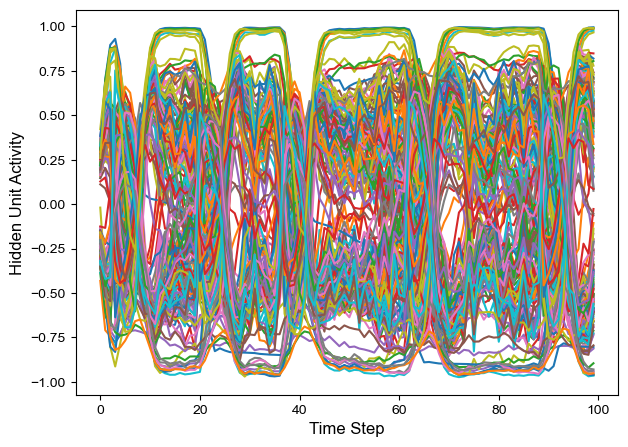

In [ ]:
# Visualise hidden unit activity for a sample trial (adapted from EIRNN code to remove the EI neurons)
trial = 0  # Select a trial to visualize
inputs, _ = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

with torch.no_grad():
    _, rnn_activity = net(inputs)  # rnn_activity shape: (seq_len, batch_size, hidden_size)

# Extract activity for the selected trial
rnn_activity_trial = rnn_activity[:, trial, :].detach().cpu().numpy()  # Shape: (seq_len, hidden_size)

plt.figure(figsize=(7, 5)) # Plot the activity of a single neuron
plt.plot(rnn_activity_trial)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Hidden Unit Activity", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()